# Параллельные вычисления

## Задачи для совместного разбора

1. Посчитайте, сколько раз встречается буква "a" в файлах ["xaa", "xab", "xac", "xad"]. 

In [1]:
!pip install pandarallel

  Created wheel for pandarallel: filename=pandarallel-1.6.3-py3-none-any.whl size=16450 sha256=1a550398471d93d11e767960c036c68a72fa8ddcf484dbc596cd4eda69216e25
  Stored in directory: c:\users\sanha\appdata\local\pip\cache\wheels\16\f5\91\d7efa7c4911ae1cf1aff825f902382eb69a1855f9987a7d17c
Successfully built pandarallel


In [2]:
import multiprocessing

In [3]:
files = [f"{name}.txt" for name in ["xaa", "xab", "xac", "xad"]]

In [4]:
from collections import Counter

def count_a(file):
    with open(file) as fp:
        text = fp.read().lower()
    res = Counter(text)["a"]
    print(file, res)
    return res

In [5]:
%%time
[count_a(f) for f in files]

xaa.txt 2599627
xab.txt 2605911
xac.txt 2599868
xad.txt 1460452
Wall time: 7.22 s


[2599627, 2605911, 2599868, 1460452]

In [6]:
%%file count_a.py
from collections import Counter

def count_a(file):
    with open(file) as fp:
        text = fp.read().lower()
    res = Counter(text)["a"]
    print(file, res)
    return res

Overwriting count_a.py


In [7]:
from count_a import count_a

In [8]:
%%time
with multiprocessing.Pool(processes=4) as pool:
    res = pool.map(count_a, files)
res

Wall time: 2.31 s


[2599627, 2605911, 2599868, 1460452]

In [9]:
%%file count_a_q.py
from collections import Counter

def count_a_q(file, queue):
    with open(file) as fp:
        text = fp.read().lower()
    res = Counter(text)["a"]
    print(file, res)
    queue.put(res)

Overwriting count_a_q.py


In [10]:
from count_a_q import count_a_q

In [11]:
%%time
ps = []
queue = multiprocessing.Queue()

for f in files:
    p = multiprocessing.Process(target=count_a_q, args=(f, queue))
    ps.append(p)
    p.start()

rs = []
while len(rs) < 4:
    if not queue.empty():
        rs.append(queue.get())
    
for p in ps:
    p.join()

rs

Wall time: 2.3 s


[1460452, 2599868, 2605911, 2599627]

2. Выведите на экран слова из файла words_alpha, в которых есть две или более буквы "e" подряд.

In [12]:
import pandas as pd

words = (
    pd.read_csv("words_alpha.txt", header=None)[0]
    .dropna()
    .sample(frac=1, replace=True)
)

In [13]:
words

190550      mythopastoral
241407            pokable
29597              beatee
248811          preperuse
104262             escudo
               ...       
227035        participles
332664               turd
67929     conveyorization
152243              infra
117748            forward
Name: 0, Length: 370103, dtype: object

In [14]:
words.size

370103

In [15]:
def f(s): 
    return bool(re.findall(r"e{2,}", s))

In [16]:
%%file f.py
import re

def f(s): 
    return bool(re.findall(r"e{2,}", s))

Overwriting f.py


In [17]:
from f import f

In [18]:
from pandarallel import pandarallel 
pandarallel.initialize()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [19]:
%%time
words[words.map(f)].size

Wall time: 346 ms


7150

In [20]:
%%time
words[words.parallel_map(f)].size

Wall time: 1.21 s


7150

## Лабораторная работа 10

__При решении данных задач не подразумевается использования циклов или генераторов Python в ходе работы с пакетами `numpy` и `pandas`, если в задании не сказано обратного. Решения задач, в которых для обработки массивов `numpy` или структур `pandas` используются явные циклы (без согласования с преподавателем), могут быть признаны некорректными и не засчитаны.__

##### Устсновим необходимые библиотеки

In [1]:
!pip install pandarallel

In [1]:
import re
import time
import psutil
import numpy as np
import pandas as pd
import multiprocessing
from itertools import chain
from operator import itemgetter
import matplotlib.pyplot as plt
from collections import Counter
from pandarallel import pandarallel
from iteration_utilities import flatten

1\. В каждой строке файла `tag_nsteps.csv` хранится информация о тэге рецепта и количестве шагов в этом рецепте в следующем виде:

```
tags,n_steps
hungarian,2
european,6
occasion,4
pumpkin,4
................
```

Всего в исходном файле хранится чуть меньше, чем 71 млн, строк. Разбейте файл `tag_nsteps.csv` на несколько (например, 8) примерно одинаковых по объему файлов c названиями `tag_nsteps_*.csv`, где вместо символа `*` указан номер очередного файла. Каждый файл имеет структуру, аналогичную оригинальному файлу (включая заголовок).

__Важно__: здесь и далее вы не можете загружать в память весь исходный файл сразу. 

In [55]:
70695586//8

8836948

In [40]:
amount_of_files = 0
for index, chunk in enumerate(pd.read_csv("tag_nsteps.csv", 
                                         chunksize=8837000)):
    amount_of_files += 1
    chunk.to_csv(f'tag_nsteps_{index+1}.csv', index=None)

In [2]:
amount_of_files = 8

2\. Напишите функцию, которая принимает на вход название файла, созданного в результате решения задачи 1, считает для каждого тэга сумму по столбцу `n_steps` и количество строк c этим тэгом, и возвращает результат в виде словаря. Ожидаемый вид итогового словаря:

```
{
    '1-day-or-more': {'sum': 56616, 'count': 12752},
    '15-minutes-or-less': {'sum': 195413, 'count': 38898},
    '3-steps-or-less': {'sum': 187938, 'count': 39711},
    ....
}
```

Примените данную функцию к каждому файлу, полученному в задании 1, и соберите результат в виде списка словарей. Не используйте параллельных вычислений. 

Выведите на экран значение по ключу "30-minutes-or-less" для каждого из словарей.

In [3]:
def get_tag_sum_count_from_file(file: str) -> dict:
    df = pd.read_csv(file)
    sums = df.groupby("tags")["n_steps"].sum()
    counts = df.groupby("tags")["n_steps"].count()
    merged_df = pd.concat([sums, counts], axis=1, keys=["sum", "count"])
    dct = merged_df.T.to_dict('dict')
    return dct

In [4]:
get_tag_sum_count_from_file("tag_nsteps_1.csv")

{'1-day-or-more': {'sum': 56402, 'count': 12707},
 '15-minutes-or-less': {'sum': 194344, 'count': 38706},
 '3-steps-or-less': {'sum': 187033, 'count': 39520},
 '30-minutes-or-less': {'sum': 347663, 'count': 45422},
 '4-hours-or-less': {'sum': 428105, 'count': 42502},
 '5-ingredients-or-less': {'sum': 178969, 'count': 33685},
 '60-minutes-or-less': {'sum': 520080, 'count': 54990},
 'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.': {'sum': 39811,
  'count': 11400},
 'a1-sauce': {'sum': 39877, 'count': 11312},
 'african': {'sum': 56935, 'count': 13092},
 'american': {'sum': 231342, 'count': 30624},
 'amish-mennonite': {'sum': 40520, 'count': 11366},
 'angolan': {'sum': 39386, 'count': 11240},
 'appetizers': {'sum': 149517, 'count': 23914},
 'apples': {'sum': 69196, 'count': 14258},
 'april-fools-day': {'sum': 39109, 'count': 11185},
 'argentine': {'sum': 40616, 'count': 11347},
 'artichoke': {'sum': 40221, 'count': 11498},
 'asian': {'sum': 127185, 'count': 19754},


In [5]:
lst_tag_sum_count = []
for file_num in range(amount_of_files):
    with open(f"tag_nsteps_{file_num+1}.csv", "r") as f: 
        lst_tag_sum_count.append(get_tag_sum_count_from_file(f))
        
lst_tag_sum_count

[{'1-day-or-more': {'sum': 56402, 'count': 12707},
  '15-minutes-or-less': {'sum': 194344, 'count': 38706},
  '3-steps-or-less': {'sum': 187033, 'count': 39520},
  '30-minutes-or-less': {'sum': 347663, 'count': 45422},
  '4-hours-or-less': {'sum': 428105, 'count': 42502},
  '5-ingredients-or-less': {'sum': 178969, 'count': 33685},
  '60-minutes-or-less': {'sum': 520080, 'count': 54990},
  'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.': {'sum': 39811,
   'count': 11400},
  'a1-sauce': {'sum': 39877, 'count': 11312},
  'african': {'sum': 56935, 'count': 13092},
  'american': {'sum': 231342, 'count': 30624},
  'amish-mennonite': {'sum': 40520, 'count': 11366},
  'angolan': {'sum': 39386, 'count': 11240},
  'appetizers': {'sum': 149517, 'count': 23914},
  'apples': {'sum': 69196, 'count': 14258},
  'april-fools-day': {'sum': 39109, 'count': 11185},
  'argentine': {'sum': 40616, 'count': 11347},
  'artichoke': {'sum': 40221, 'count': 11498},
  'asian': {'sum': 12718

In [6]:
thirty_min_of_less = list(map(lambda x: x.get("30-minutes-or-less", {}), lst_tag_sum_count))
thirty_min_of_less

[{'sum': 347663, 'count': 45422},
 {'sum': 348230, 'count': 45827},
 {'sum': 352500, 'count': 46137},
 {'sum': 346156, 'count': 45423},
 {'sum': 344722, 'count': 45413},
 {'sum': 349198, 'count': 45886},
 {'sum': 345140, 'count': 45606},
 {'sum': 349596, 'count': 46068}]

3\. Напишите функцию, которая объединяет результаты обработки отдельных файлов. Данная функция принимает на вход список словарей, каждый из которых является результатом вызова функции `get_tag_sum_count_from_file` для конкретного файла, и агрегирует эти словари. Не используйте параллельных вычислений.

Процедура агрегации словарей имеет следующий вид:
$$d_{agg}[k] = \{sum: \sum_{i=1}^{n}d_{i}[k][sum], count: \sum_{i=1}^{n}d_{i}[k][count]\}$$
где $d_1, d_2, ..., d_n$- результат вызова функции `get_tag_sum_count_from_file` для конкретных файлов.

Примените данную функцию к результату выполнения задания 2. Выведите на экран результат для тэга "30-minutes-or-less".

In [7]:
def agg_results(tag_sum_count_list: list) -> dict:
    keys = list(tag_sum_count_list[0].keys())
    lst_of_lsts_for_tags = [list(map(lambda x: x.get(keys[tag_i], {}), tag_sum_count_list)) for tag_i in range(len(keys))]
    result = {keys[lst_i]: dict(pd.DataFrame(lst_of_lsts_for_tags[lst_i]).sum()) for lst_i in range(len(lst_of_lsts_for_tags))}
    return result

In [8]:
agg_sum_count = agg_results(lst_tag_sum_count)
agg_sum_count

{'1-day-or-more': {'sum': 445183, 'count': 99994},
 '15-minutes-or-less': {'sum': 1547424, 'count': 310334},
 '3-steps-or-less': {'sum': 1491237, 'count': 315807},
 '30-minutes-or-less': {'sum': 2783205, 'count': 365782},
 '4-hours-or-less': {'sum': 3423888, 'count': 339507},
 '5-ingredients-or-less': {'sum': 1431950, 'count': 268658},
 '60-minutes-or-less': {'sum': 4161560, 'count': 441806},
 'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.': {'sum': 319572,
  'count': 91099},
 'a1-sauce': {'sum': 322070, 'count': 91445},
 'african': {'sum': 459437, 'count': 105525},
 'american': {'sum': 1860381, 'count': 245764},
 'amish-mennonite': {'sum': 326639, 'count': 91688},
 'angolan': {'sum': 313213, 'count': 89884},
 'appetizers': {'sum': 1188876, 'count': 190801},
 'apples': {'sum': 556755, 'count': 114500},
 'april-fools-day': {'sum': 314896, 'count': 89701},
 'argentine': {'sum': 322047, 'count': 90095},
 'artichoke': {'sum': 319312, 'count': 91307},
 'asian': {'sum

In [9]:
agg_sum_count.get("30-minutes-or-less")

{'sum': 2783205, 'count': 365782}

4\. Напишите функцию, которая считает среднее значение количества шагов для каждого тэга в словаре, имеющего вид, аналогичный словарям в задаче 2, и возвращает результат в виде словаря . Используйте решения задач 1-3, чтобы получить среднее значение количества шагов каждого тэга для всего датасета, имея результаты обработки частей датасета и результат их агрегации. Выведите на экран результат для тэга "30-minutes-or-less".

Определите, за какое время задача решается для всего датасета. При замере времени учитывайте время расчета статистики для каждого файла, агрегации результатов и, собственно, вычисления средного. Временем, затрачиваемым на процедуру разбиения исходного файла можно пренебречь.

In [10]:
def get_tag_mean_n_steps(tag_sum_count: dict) -> dict:
    keys = list(tag_sum_count.keys())
    sum_and_count_arr = np.array(list(map(lambda d: [d['sum'], d['count']], list(tag_sum_count.values()))))
    sum_and_count_arr = np.array_split(sum_and_count_arr, 2, axis=1)
    mean_steps = np.divide(sum_and_count_arr[0], sum_and_count_arr[1])
    df_mean = pd.DataFrame(data=mean_steps, index=keys, columns=['mean'])
    df_mean = df_mean.to_dict('index')
    return df_mean

In [11]:
%%time

def create_list(n_files):
    lst_tag_sum_count = []
    
    for file_num in range(n_files):
        with open(f"tag_nsteps_{file_num+1}.csv", "r") as f: 
            lst_tag_sum_count.append(get_tag_sum_count_from_file(f))
            
    return lst_tag_sum_count

res_4 = get_tag_mean_n_steps(agg_results(create_list(amount_of_files)))
res_4

Wall time: 22.7 s


{'1-day-or-more': {'mean': 4.4520971258275495},
 '15-minutes-or-less': {'mean': 4.986317967093519},
 '3-steps-or-less': {'mean': 4.721988429642155},
 '30-minutes-or-less': {'mean': 7.608917333275011},
 '4-hours-or-less': {'mean': 10.084881902287728},
 '5-ingredients-or-less': {'mean': 5.330010645504694},
 '60-minutes-or-less': {'mean': 9.41942843691575},
 'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.': {'mean': 3.507963863489171},
 'a1-sauce': {'mean': 3.522007764229865},
 'african': {'mean': 4.353821369343757},
 'american': {'mean': 7.5697864618088895},
 'amish-mennonite': {'mean': 3.5625054532763283},
 'angolan': {'mean': 3.484635752747986},
 'appetizers': {'mean': 6.230973632213668},
 'apples': {'mean': 4.862489082969432},
 'april-fools-day': {'mean': 3.5105071292404766},
 'argentine': {'mean': 3.5745268882845886},
 'artichoke': {'mean': 3.497125083509479},
 'asian': {'mean': 6.454297045484734},
 'asparagus': {'mean': 4.07156120698355},
 'australian': {'mean

In [12]:
res_4.get("30-minutes-or-less")

{'mean': 7.608917333275011}

5\. Повторите решение задачи 4, распараллелив вызовы функции `get_tag_sum_count_from_file` для различных файлов с помощью `multiprocessing.Pool`. Для обработки каждого файла создайте свой собственный процесс. Выведите на экран результат для тэга "30-minutes-or-less". Определите, за какое время задача решается для всех файлов. При замере времени учитывайте время расчета статистики для каждого файла, агрегации результатов и, собственно, вычисления средного. Временем, затрачиваемым на процедуру разбиения исходного файла можно пренебречь.

In [13]:
%%file multi_get_tag_sum_count_from_file.py
import numpy as np
import pandas as pd

def get_tag_sum_count_from_file(file: str) -> dict:
    df = pd.read_csv(file)
    sums = df.groupby("tags")["n_steps"].sum()
    counts = df.groupby("tags")["n_steps"].count()
    merged_df = pd.concat([sums, counts], axis=1, keys=["sum", "count"])
    dct = merged_df.T.to_dict('dict')
    return dct

Overwriting multi_get_tag_sum_count_from_file.py


In [14]:
%%time

files = [f"tag_nsteps_{i+1}.csv" for i in range(amount_of_files)]
from multi_get_tag_sum_count_from_file import get_tag_sum_count_from_file
with multiprocessing.Pool(processes=amount_of_files) as pool:
    res = list(pool.map(get_tag_sum_count_from_file, files))

def agg_and_mean(tag_sum_count_list: list) -> dict:
    keys = list(pd.unique(pd.Series(list(chain.from_iterable(tag_sum_count_list)))))
    lst_of_lsts_for_tags = [list(map(lambda x: x.setdefault(keys[tag_i], {}), tag_sum_count_list)) for tag_i in range(len(keys))]
    dct_tag_sum_count = {keys[lst_i]: dict(pd.DataFrame(lst_of_lsts_for_tags[lst_i]).sum()) for lst_i in range(len(lst_of_lsts_for_tags))}
    sum_and_count_arr = np.array(list(map(lambda d: [d['sum'], d['count']], list(dct_tag_sum_count.values()))))
    sum_and_count_arr = np.array_split(sum_and_count_arr, 2, axis=1)
    mean_steps = np.divide(sum_and_count_arr[0], sum_and_count_arr[1])
    dct_mean = pd.DataFrame(data=mean_steps, index=keys, columns=['mean'])
    dct_mean = dct_mean.to_dict('index')
    return dct_mean

multi_dct_mean = agg_and_mean(res)
multi_dct_mean

Wall time: 4.58 s


{'1-day-or-more': {'mean': 4.4520971258275495},
 '15-minutes-or-less': {'mean': 4.986317967093519},
 '3-steps-or-less': {'mean': 4.721988429642155},
 '30-minutes-or-less': {'mean': 7.608917333275011},
 '4-hours-or-less': {'mean': 10.084881902287728},
 '5-ingredients-or-less': {'mean': 5.330010645504694},
 '60-minutes-or-less': {'mean': 9.41942843691575},
 'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.': {'mean': 3.507963863489171},
 'a1-sauce': {'mean': 3.522007764229865},
 'african': {'mean': 4.353821369343757},
 'american': {'mean': 7.5697864618088895},
 'amish-mennonite': {'mean': 3.5625054532763283},
 'angolan': {'mean': 3.484635752747986},
 'appetizers': {'mean': 6.230973632213668},
 'apples': {'mean': 4.862489082969432},
 'april-fools-day': {'mean': 3.5105071292404766},
 'argentine': {'mean': 3.5745268882845886},
 'artichoke': {'mean': 3.497125083509479},
 'asian': {'mean': 6.454297045484734},
 'asparagus': {'mean': 4.07156120698355},
 'australian': {'mean

6\. Повторите решение задачи 4, распараллелив вычисления функции `get_tag_sum_count_from_file` для различных файлов с помощью `multiprocessing.Process`. Для обработки каждого файла создайте свой собственный процесс. Для обмена данными между процессами используйте `multiprocessing.Queue`.

Выведите на экран результат для тэга "30-minutes-or-less". Определите, за какое время задача решается для всех файлов. При замере времени учитывайте время расчета статистики для каждого файла, агрегации результатов и, собственно, вычисления средного. Временем, затрачиваемым на процедуру разбиения исходного файла можно пренебречь.

In [15]:
%%file get_tag_sum_count_from_file_queue.py
import numpy as np
import pandas as pd

def get_tag_sum_count_from_file_q(file, queue):
    df = pd.read_csv(file)
    sums = df.groupby("tags")["n_steps"].sum()
    counts = df.groupby("tags")["n_steps"].count()
    merged_df = pd.concat([sums, counts], axis=1, keys=["sum", "count"])
    dct = merged_df.T.to_dict('dict')
    queue.put(dct)

Overwriting get_tag_sum_count_from_file_queue.py


In [16]:
from get_tag_sum_count_from_file_queue import get_tag_sum_count_from_file_q

In [ ]:
%%time
ps = []
queue = multiprocessing.Queue()

files = [f"tag_nsteps_{i+1}.csv" for i in range(amount_of_files)]
for f in files:
    p = multiprocessing.Process(target=get_tag_sum_count_from_file_q, args=(f, queue))
    ps.append(p)
    p.start()

rs = []
while not queue.empty():
    if not queue.empty():
        rs.append(queue.get())
    
for p in ps:
    p.join()

agg_and_mean(rs)

7\. Исследуйте, как влияет количество запущенных одновременно процессов на скорость решения задачи. Узнайте количество ядер вашего процессора $K$. Повторите решение задачи 1, разбив исходный файл на $\frac{K}{2}$, $K$ и $2K$ фрагментов. Для каждого из разбиений повторите решение задачи 5. Визуализируйте зависимость времени выполнения кода от количества файлов в разбиении. Сделайте вывод в виде текстового комментария.

Так как у меня два компьютера, которые имеют разное количество ядер, то ответ в данном задании будет зависеть от того на каком компьютере я выполнял ячейку. 

Характеристики: 

    * ПК - (AMD Ryzen™ 7 3700X, # of CPU Cores: 8, # of Threads: 16)

    * Ноутбук - (i3-10110U, Количество ядер: 2, Количество потоков: 4)

In [120]:
cores = multiprocessing.cpu_count()
cores

4

In [122]:
k_div_2 = cores/2
k = cores
k_2 = cores*2
print("k/2: ", k_div_2, "\n", "k: ", k, "\n", "2*k: ", k_2)

k/2:  2.0 
 k:  4 
 2*k:  8


### k/2

In [123]:
70695586/k_div_2

35347793.0

In [124]:
chunk_k_div_2 = int(70695586//k_div_2)
chunk_k_div_2

35347793

In [125]:
amount_of_files_number_7_k_div_2 = 0
for index, chunk in enumerate(pd.read_csv("tag_nsteps.csv", 
                                         chunksize=chunk_k_div_2)):
    amount_of_files_number_7_k_div_2 += 1
    chunk.to_csv(f'tag_nsteps_{index+1}_number_7_k_div_2.csv', index=None)

In [127]:
%%time

start_time = time.time()
files_num_7_k_div_2 = [f"tag_nsteps_{i+1}_number_7_k_div_2.csv" for i in range(amount_of_files_number_7_k_div_2)]
from multi_get_tag_sum_count_from_file import get_tag_sum_count_from_file
with multiprocessing.Pool(processes=amount_of_files_number_7_k_div_2) as pool:
    res_num_7_k_div_2 = list(pool.map(get_tag_sum_count_from_file, files_num_7_k_div_2))

# def agg_and_mean(tag_sum_count_list: list) -> dict:
#     keys = list(pd.unique(pd.Series(list(chain.from_iterable(tag_sum_count_list)))))
#     lst_of_lsts_for_tags = [list(map(lambda x: x.setdefault(keys[tag_i], {}), tag_sum_count_list)) for tag_i in range(len(keys))]
#     dct_tag_sum_count = {keys[lst_i]: dict(pd.DataFrame(lst_of_lsts_for_tags[lst_i]).sum()) for lst_i in range(len(lst_of_lsts_for_tags))}
#     sum_and_count_arr = np.array(list(map(lambda d: [d['sum'], d['count']], list(dct_tag_sum_count.values()))))
#     sum_and_count_arr = np.array_split(sum_and_count_arr, 2, axis=1)
#     mean_steps = np.divide(sum_and_count_arr[0], sum_and_count_arr[1])
#     dct_mean = pd.DataFrame(data=mean_steps, index=keys, columns=['mean'])
#     dct_mean = dct_mean.to_dict('index')
#     return dct_mean

multi_dct_mean_k_div_2 = agg_and_mean(res_num_7_k_div_2)
spended_time_k_div_2 = round(time.time() - start_time, 2)
print(spended_time_k_div_2, "s")
multi_dct_mean_k_div_2

35.2 s
Wall time: 35.2 s


{'1-day-or-more': {'mean': 4.4520971258275495},
 '15-minutes-or-less': {'mean': 4.986317967093519},
 '3-steps-or-less': {'mean': 4.721988429642155},
 '30-minutes-or-less': {'mean': 7.608917333275011},
 '4-hours-or-less': {'mean': 10.084881902287728},
 '5-ingredients-or-less': {'mean': 5.330010645504694},
 '60-minutes-or-less': {'mean': 9.41942843691575},
 'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.': {'mean': 3.507963863489171},
 'a1-sauce': {'mean': 3.522007764229865},
 'african': {'mean': 4.353821369343757},
 'american': {'mean': 7.5697864618088895},
 'amish-mennonite': {'mean': 3.5625054532763283},
 'angolan': {'mean': 3.484635752747986},
 'appetizers': {'mean': 6.230973632213668},
 'apples': {'mean': 4.862489082969432},
 'april-fools-day': {'mean': 3.5105071292404766},
 'argentine': {'mean': 3.5745268882845886},
 'artichoke': {'mean': 3.497125083509479},
 'asian': {'mean': 6.454297045484734},
 'asparagus': {'mean': 4.07156120698355},
 'australian': {'mean

### k

In [128]:
70695586/k

17673896.5

In [129]:
chunk_k = 70695586//k + 1
chunk_k

17673897

In [130]:
amount_of_files_number_7_k = 0
for index, chunk in enumerate(pd.read_csv("tag_nsteps.csv", 
                                         chunksize=chunk_k)):
    amount_of_files_number_7_k += 1
    chunk.to_csv(f'tag_nsteps_{index+1}_number_7_k.csv', index=None)

In [131]:
%%time

start_time = time.time()
files_num_7_k = [f"tag_nsteps_{i+1}_number_7_k.csv" for i in range(amount_of_files_number_7_k)]
from multi_get_tag_sum_count_from_file import get_tag_sum_count_from_file
with multiprocessing.Pool(processes=amount_of_files_number_7_k) as pool:
    res_num_7_k = list(pool.map(get_tag_sum_count_from_file, files_num_7_k))

# def agg_and_mean(tag_sum_count_list: list) -> dict:
#     keys = list(pd.unique(pd.Series(list(chain.from_iterable(tag_sum_count_list)))))
#     lst_of_lsts_for_tags = [list(map(lambda x: x.setdefault(keys[tag_i], {}), tag_sum_count_list)) for tag_i in range(len(keys))]
#     dct_tag_sum_count = {keys[lst_i]: dict(pd.DataFrame(lst_of_lsts_for_tags[lst_i]).sum()) for lst_i in range(len(lst_of_lsts_for_tags))}
#     sum_and_count_arr = np.array(list(map(lambda d: [d['sum'], d['count']], list(dct_tag_sum_count.values()))))
#     sum_and_count_arr = np.array_split(sum_and_count_arr, 2, axis=1)
#     mean_steps = np.divide(sum_and_count_arr[0], sum_and_count_arr[1])
#     dct_mean = pd.DataFrame(data=mean_steps, index=keys, columns=['mean'])
#     dct_mean = dct_mean.to_dict('index')
#     return dct_mean

multi_dct_mean_k = agg_and_mean(res_num_7_k)
spended_time_k = round(time.time() - start_time, 2)
print(spended_time_k, "s")
multi_dct_mean_k

23.14 s
Wall time: 23.1 s


{'1-day-or-more': {'mean': 4.4520971258275495},
 '15-minutes-or-less': {'mean': 4.986317967093519},
 '3-steps-or-less': {'mean': 4.721988429642155},
 '30-minutes-or-less': {'mean': 7.608917333275011},
 '4-hours-or-less': {'mean': 10.084881902287728},
 '5-ingredients-or-less': {'mean': 5.330010645504694},
 '60-minutes-or-less': {'mean': 9.41942843691575},
 'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.': {'mean': 3.507963863489171},
 'a1-sauce': {'mean': 3.522007764229865},
 'african': {'mean': 4.353821369343757},
 'american': {'mean': 7.5697864618088895},
 'amish-mennonite': {'mean': 3.5625054532763283},
 'angolan': {'mean': 3.484635752747986},
 'appetizers': {'mean': 6.230973632213668},
 'apples': {'mean': 4.862489082969432},
 'april-fools-day': {'mean': 3.5105071292404766},
 'argentine': {'mean': 3.5745268882845886},
 'artichoke': {'mean': 3.497125083509479},
 'asian': {'mean': 6.454297045484734},
 'asparagus': {'mean': 4.07156120698355},
 'australian': {'mean

### 2k

In [132]:
70695586/k_2

8836948.25

In [133]:
chunk_k_2 = 70695586//k_2 + 1
chunk_k_2

8836949

In [134]:
amount_of_files_number_7_k_2 = 0
for index, chunk in enumerate(pd.read_csv("tag_nsteps.csv", 
                                         chunksize=chunk_k_2)):
    amount_of_files_number_7_k_2 += 1
    chunk.to_csv(f'tag_nsteps_{index+1}_number_7_k_2.csv', index=None)

In [135]:
%%time

start_time = time.time()
files_num_7_k_2 = [f"tag_nsteps_{i+1}_number_7_k_2.csv" for i in range(amount_of_files_number_7_k_2)]
from multi_get_tag_sum_count_from_file import get_tag_sum_count_from_file
with multiprocessing.Pool(processes=amount_of_files_number_7_k_2) as pool:
    res_num_7_k_2 = list(pool.map(get_tag_sum_count_from_file, files_num_7_k_2))

# def agg_and_mean(tag_sum_count_list: list) -> dict:
#     keys = list(pd.unique(pd.Series(list(chain.from_iterable(tag_sum_count_list)))))
#     lst_of_lsts_for_tags = [list(map(lambda x: x.setdefault(keys[tag_i], {}), tag_sum_count_list)) for tag_i in range(len(keys))]
#     dct_tag_sum_count = {keys[lst_i]: dict(pd.DataFrame(lst_of_lsts_for_tags[lst_i]).sum()) for lst_i in range(len(lst_of_lsts_for_tags))}
#     sum_and_count_arr = np.array(list(map(lambda d: [d['sum'], d['count']], list(dct_tag_sum_count.values()))))
#     sum_and_count_arr = np.array_split(sum_and_count_arr, 2, axis=1)
#     mean_steps = np.divide(sum_and_count_arr[0], sum_and_count_arr[1])
#     dct_mean = pd.DataFrame(data=mean_steps, index=keys, columns=['mean'])
#     dct_mean = dct_mean.to_dict('index')
#     return dct_mean

multi_dct_mean_k_2 = agg_and_mean(res_num_7_k_2)
spended_time_k_2 = round(time.time() - start_time, 2)
print(spended_time_k_2, "s")
multi_dct_mean_k_2

24.12 s
Wall time: 24.1 s


{'1-day-or-more': {'mean': 4.4520971258275495},
 '15-minutes-or-less': {'mean': 4.986317967093519},
 '3-steps-or-less': {'mean': 4.721988429642155},
 '30-minutes-or-less': {'mean': 7.608917333275011},
 '4-hours-or-less': {'mean': 10.084881902287728},
 '5-ingredients-or-less': {'mean': 5.330010645504694},
 '60-minutes-or-less': {'mean': 9.41942843691575},
 'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.': {'mean': 3.507963863489171},
 'a1-sauce': {'mean': 3.522007764229865},
 'african': {'mean': 4.353821369343757},
 'american': {'mean': 7.5697864618088895},
 'amish-mennonite': {'mean': 3.5625054532763283},
 'angolan': {'mean': 3.484635752747986},
 'appetizers': {'mean': 6.230973632213668},
 'apples': {'mean': 4.862489082969432},
 'april-fools-day': {'mean': 3.5105071292404766},
 'argentine': {'mean': 3.5745268882845886},
 'artichoke': {'mean': 3.497125083509479},
 'asian': {'mean': 6.454297045484734},
 'asparagus': {'mean': 4.07156120698355},
 'australian': {'mean

In [136]:
df_summar = pd.DataFrame(data={'time': [spended_time_k_div_2, spended_time_k, spended_time_k_2],
                               'n_files': [amount_of_files_number_7_k_div_2, amount_of_files_number_7_k, amount_of_files_number_7_k_2]})
df_summar

,time,n_files
0,35.20,2
1,23.14,4
2,24.12,8


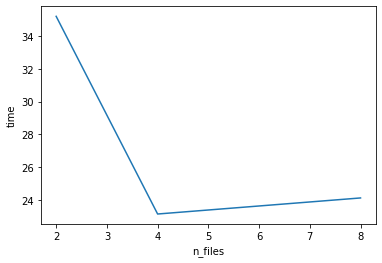

In [140]:
plt.plot(df_summar.n_files, df_summar.time)
plt.xlabel('n_files')
plt.ylabel('time')
plt.show()

##### Можем наблюдать что при уменьшении количества файлов время требуемое на обработку файла увеличивается

8\. Напишите функцию `parallel_map`, которая принимает на вход серию `s` `pd.Series` и функцию одного аргумента `f` и поэлементно применяет эту функцию к серии, распараллелив вычисления при помощи пакета `multiprocessing`. Логика работы функции `parallel_map` должна включать следующие действия:
* разбиение исходной серии на $K$ частей, где $K$ - количество ядер вашего процессора;
* параллельное применение функции `f` к каждой части при помощи метода _серии_ `map` при помощи нескольких подпроцессов;
* объединение результатов работы подпроцессов в одну серию. 

In [50]:
def parallel_map(s: pd.Series, f: callable) -> pd.Series:
    s_split = np.array_split(s, 8)
    split_bool = []
    for df_sp in range(len(s_split)):
        with multiprocessing.Pool(processes=len(s_split)) as pool:
            split_bool.append(list(pool.map(f, s_split[df_sp].tags)))
    series_flat_split_bool = pd.Series(list(flatten(split_bool)))
    return series_flat_split_bool

9\. Напишите функцию `f`, которая принимает на вход тэг и проверяет, удовлетворяет ли тэг следующему шаблону: `[любое число]-[любое слово]-or-less`. Возьмите любой фрагмент файла, полученный в задании 1, примените функцию `f` при помощи `parallel_map` к столбцу `tags` и посчитайте количество тэгов, подходящих под этот шаблон. Решите ту же задачу, воспользовавшись методом _серий_ `map`. Сравните время и результат выполнения двух решений.

In [51]:
%%file f.py
import re

def f(tag: str) -> bool:
    patt = re.compile(r"[\d]+-[\w]+-(?:or-less)")
    find = patt.findall(str(tag))
    res = False if not find else True
    return res

Overwriting f.py


In [52]:
%%time

from f import f

parallel_map(pd.read_csv('tag_nsteps_1.csv'), f)

Wall time: 15.7 s


0          False
1          False
2          False
3          False
4          False
           ...  
8836995    False
8836996    False
8836997    False
8836998    False
8836999    False
Length: 8837000, dtype: bool

In [53]:
%%time

df_nsteps_1 = pd.read_csv('tag_nsteps_1.csv')
df_nsteps_1['tags'].map(f)

Wall time: 28.2 s


0          False
1          False
2          False
3          False
4          False
           ...  
8836995    False
8836996    False
8836997    False
8836998    False
8836999    False
Name: tags, Length: 8837000, dtype: bool

##### с помощью parallel_map ф-ция работает быстрее примерно в 2 раза

10\. Используя пакет `pandarallel`, примените функцию `f` из задания 9 к столбцу `tags` таблицы, с которой вы работали этом задании. Посчитайте количество тэгов, подходящих под описанный шаблон. Измерьте время выполнения кода. Выведите на экран полученный результат.

In [54]:
pandarallel.initialize()

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [55]:
%%time

df_nsteps_1['tags'].parallel_map(f)

Wall time: 8.36 s


0          False
1          False
2          False
3          False
4          False
           ...  
8836995    False
8836996    False
8836997    False
8836998    False
8836999    False
Name: tags, Length: 8837000, dtype: bool

In [56]:
print("Количество тэгов, подходящих под описанный шаблон: ", df_nsteps_1['tags'].parallel_map(f).sum())

Количество тэгов, подходящих под описанный шаблон:  254825
